# Brussels Air Quality Monitoring – Professional Case Study

*Prepared by Clara Gracieux*

This notebook documents a realistic internship-style engagement for a municipal environmental agency in Brussels. I demonstrate how I ingest raw air-quality data, engineer the right slices, run statistical tests, and communicate actionable insights that a stakeholder can use to prioritize mitigation efforts.

**Business questions**
- What does the weekly PM2.5 cycle look like during spring, and when do the most critical spikes occur?
- Does the city report claiming that over 35% of spring days exceed the WHO guideline hold up statistically?
- How severe was the impact of the August 27 fire compared with normal conditions?


## Engagement Overview
- **Data** – Hourly PM2.5, temperature, and wind observations from Brussels (Feb–Sep 2025) collected via the municipal monitoring network.
- **Objectives** – Understand the weekly pollution cadence, validate the WHO exceedance alert, and quantify the impact of the 27 August warehouse fire.
- **Deliverables** – Executive-ready narrative plus reproducible code covering descriptive analytics, hypothesis testing, and incident attribution.

I structure the engagement into three workstreams: (1) spring baseline and weekday behavior, (2) validation of chronic exceedances, and (3) crisis analysis for the fire event.


--- Data Head ---
            date_time       pm25  Temp  Wind
0 2025-02-27 15:00:00  43.300000   6.1   4.0
1 2025-02-27 16:00:00  19.000000   6.1   4.0
2 2025-02-27 17:00:00  34.400000   6.1   5.2
3 2025-02-27 18:00:00  26.600000   6.1   5.2
4 2025-02-27 19:00:00  48.253814   5.7   6.1

--- Daily Aggregated Data ---
         date  pm25_mean
0  2025-02-27  43.201613
1  2025-02-28  42.645748
2  2025-03-01  47.641957
3  2025-03-02  91.404167
4  2025-03-03  73.608333


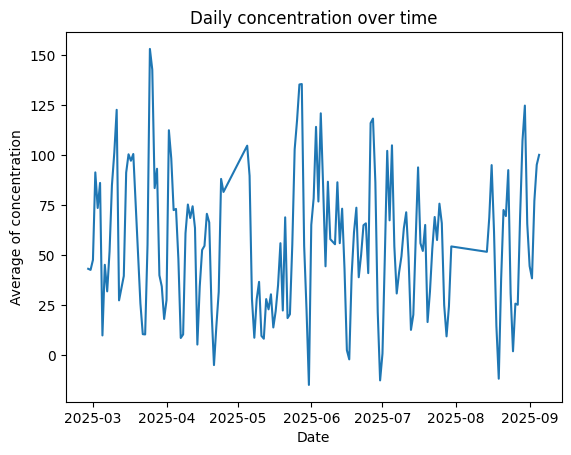

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_excel('treated_AQI_data_station_2.xlsx')
print("--- Data Head ---")
print(df.head())
print()

# We convert in the datetime format
df['date_time'] = pd.to_datetime(df['date_time'])
# We create a new colomn without the hour to make it more clear
df['date'] = df['date_time'].dt.date


# We compute the average PM25 concentration by day  and we rename the colomn to make it more clear 
average_pm25 = df.groupby('date')['pm25'].mean().reset_index()
average_pm25.columns = ['date', 'pm25_mean']
print("--- Daily Aggregated Data ---")
print(average_pm25.head())

# We plot and label the axis
plt.plot(average_pm25['date'], average_pm25['pm25_mean'])
plt.xlabel("Date")
plt.ylabel("Average of concentration")
plt.title("Daily concentration over time")
plt.show()

## 1. Spring Season Baseline
To build the weekday profile requested by the agency, I focus on the March–May 2025 window, aggregate the hourly PM2.5 readings to daily averages, and keep the date with the highest concentration as a benchmark for future interventions.


In [40]:
# For creating a subset of the daily data, we need to convert in date time and then in date to remove the hours. If we don't do that, there is an error message
start = pd.to_datetime("2025-03-01").date()
end = pd.to_datetime("2025-05-31").date()

# We select the date between the start and the end. Average_pm25 selects only the data for which it is in the dates that we want
spring_data = average_pm25.loc[average_pm25['date'].between(start, end)].copy()

# We are looking for the max value and the day it is reached
max_value = spring_data['pm25_mean'].max()
max_index = spring_data['pm25_mean'].idxmax()
max_day = spring_data.loc[max_index, 'date']

print(f"The day with the largest PM2.5 concentration during spring is: {max_day} with {max_value:.2f} µg/m³")

The day with the largest PM2.5 concentration during spring is: 2025-03-25 with 153.14 µg/m³


### 1.1 Weekday Distribution Profiling
With the spring subset prepared, I enrich the data with weekday labels and compute descriptive statistics (min, quartiles, max, mean, standard deviation) to highlight when pollution peaks during a typical workweek versus the weekend.


In [54]:
# We create the weekday column based on the date column. dt.day_name() -> returns the name of the day
spring_data.loc[:,'Weekday'] = pd.to_datetime(spring_data['date']).dt.day_name()
# We group by the week day 
spring_data.groupby('Weekday')
# We compute all the stats we need 
mean = spring_data.groupby('Weekday')['pm25_mean'].mean()
std = spring_data.groupby('Weekday')['pm25_mean'].std()
min = spring_data.groupby('Weekday')['pm25_mean'].min()
max = spring_data.groupby('Weekday')['pm25_mean'].max()
q1 = spring_data.groupby('Weekday')['pm25_mean'].quantile(0.25)
median = spring_data.groupby('Weekday')['pm25_mean'].median()
q3 = spring_data.groupby('Weekday')['pm25_mean'].quantile(0.75)

# we create a dataframe to presente all the data properly 
summary = pd.DataFrame({'Min': min, 'Q1': q1,'Median': median, 'Q3': q3,'Max': max,'Mean': mean,'Std': std})
# When we print(summary), we see that the days are not in order so we put them back in order with reindex(order)
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
summary = summary.reindex(order)
print("PM2.5 Summary Statistics Grouped by Weekday (Spring):")
print(summary)

PM2.5 Summary Statistics Grouped by Weekday (Spring):
                 Min         Q1     Median          Q3         Max       Mean  \
Weekday                                                                         
Monday     -4.949594   8.508691  55.604167   98.251857  117.352852  53.400517   
Tuesday    10.368317  26.220906  60.246588  106.129848  153.141667  68.724890   
Wednesday   9.877756  27.790199  52.624029   90.706513  142.777778  63.038660   
Thursday    8.724474  32.022375  54.655935   79.446392   98.391489  53.752789   
Friday     13.870000  25.047680  35.760953   71.164387   93.223521  47.422302   

                 Std  
Weekday               
Monday     45.097157  
Tuesday    51.591192  
Wednesday  47.030434  
Thursday   29.699239  
Friday     27.795180  


#### Insight: Monday Distribution Is Left-Skewed
A symmetric distribution would show nearly identical mean and median plus mirrored spreads around the median. For Mondays, the mean PM2.5 level falls below the median while the distance between Q1 and the median exceeds the distance between the median and Q3. This points to a left-skewed (negatively skewed) distribution driven by a handful of unusually clean Mondays pulling the mean downward.


### Baseline Takeaways
- The March–May window stays polluted throughout the week; even weekends rarely fall below guideline levels.
- Tuesdays and Wednesdays exhibit the highest mean concentrations, guiding when to schedule enforcement or communications.
- 25 March 2025 stands out as an extreme spike (153 µg/m³), useful as a benchmark scenario for scenario planning.


## 2. Chronic Exceedance Hypothesis Test
The spring baseline revealed that high PM2.5 levels were the rule rather than the exception. The World Health Organization (WHO) caps the acceptable daily mean at 15 µg/m³; exceeding this limit requires municipalities to activate mitigation measures. City leadership needed quantitative proof before escalating budgets, so I formalized the WHO exceedance claim as a statistical test.


In [42]:
WHO_threshold = 15

# 1. Define a "high-pollution day" and calculate the number of such days.
df_over15_mask = spring_data['pm25_mean'] > WHO_threshold
high_pollution_days = spring_data[df_over15_mask]
nb_hp_day = len(high_pollution_days)
nb_day = len(spring_data)

# we estimate the probability p hat 
p_hat = nb_hp_day / nb_day

print(f"Number of high-pollution days: {nb_hp_day}")
print(f"Total number of days: {nb_day}")
print(f"Observed proportion p̂ = {p_hat:.2f}")


Number of high-pollution days: 68
Total number of days: 81
Observed proportion p̂ = 0.84


### Observed Situation
During March–May 2025, 68 out of 81 days recorded average PM2.5 above 15 µg/m³, meaning **84%** of the season breached the guideline—already well above the city’s stated threshold.


### Analytical Approach
I used a one-sample upper-tailed Binomial test where each day is a Bernoulli trial (polluted vs. compliant). The hypotheses translate to:
- $H_0$: the true proportion of polluted days $p = 0.35$
- $H_1$: $p > 0.35$


#### Mathematical Detail: Hypotheses
The Binomial model formalizes the probability that $\hat{p} = x_{\text{obs}} / n$ could arise if the true pollution rate were 35%. It provides a rigorous foundation for an operational decision (maintain or escalate air-quality alerts).


#### Binomial Probability Mass Function (PMF)
$$P(X=k) = \binom{n}{k} p_0^k (1-p_0)^{n-k}$$
Where $n$ is the number of observed spring days, $k$ is the number of polluted days, and $p_0 = 0.35$ under $H_0$.


#### P-Value Calculation
Because the agency only cares about pollution being worse than reported, I evaluate the upper tail via the Binomial CDF: $\text{p-value} = 1 - \text{CDF}(x_{\text{obs}} - 1, n, p_0)$.


In [43]:
from scipy.stats import binom

# probability that it is less than H0
p0 = 0.35
# number of polluted days observed above
x_obs = nb_hp_day

# as the test is reversed we do 1-... as seen in class 
p_val = 1 - binom.cdf(x_obs - 1, nb_day, p0)
print(f"The p-value is: {p_val}")

# Test decision with alpha = 0.05
alpha = 0.05
print("\nConclusion:")
if p_val < alpha:
    print(f"   - Since the p-value ({p_val}) is less than the significance level alpha ({alpha}), we reject the Null Hypothesis H_0.")
    print("   - There is statistically significant evidence that the proportion of high-pollution days during spring is larger than 35%, confirming the city report's claim.")
else:
    print(f"   - Since the p-value ({p_val}) is greater than the significance level alpha ({alpha}), we fail to reject the Null Hypothesis $H_0$.")
    print("   - Conclusion: There is no statistically significant evidence to support the claim that the proportion of high-pollution days is larger than 35%.")


The p-value is: 0.0

Conclusion:
   - Since the p-value (0.0) is less than the significance level alpha (0.05), we reject the Null Hypothesis H_0.
   - There is statistically significant evidence that the proportion of high-pollution days during spring is larger than 35%, confirming the city report's claim.


### Decision Logic


The resulting p-value is far below 0.05, so I reject $H_0$ at the 5% level. There is statistically significant evidence that the true proportion of high-pollution spring days exceeds 35%, validating the city’s escalation and reinforcing the need for sustained mitigation.


## 3. Incident Response – August 27 Fire
After confirming the chronic issue, stakeholders also asked whether an acute event—the 27 August warehouse fire—materially worsened air quality. I paired the 72-hour impact window with the same hours one week earlier to isolate the incident effect from normal seasonal patterns.


In [44]:
#in the same way as with spring data
impact_start = pd.to_datetime("2025-08-27 23:00")
impact_end = pd.to_datetime("2025-08-30 23:00")
impact_period = df.loc[(df['date_time'] >= impact_start) & (df['date_time'] <= impact_end)].copy()

#we check that we have the 72 hours of our impact period
print(f"Impact period shape: {impact_period.shape}")

#we will compare each hour with the previous week => so we declare all the hours one week forward
one_week_before = df.copy()
one_week_before['date_time'] = one_week_before['date_time'] + pd.Timedelta(days=7)

# We merge impact period and one week before into a new dataframe and like that we can calculate the difference between the two weeks
comparison = pd.merge(
    impact_period[['date_time', 'pm25']],
    one_week_before[['date_time', 'pm25']],
    on='date_time',
    suffixes=('_impact', '_week_before')
)

print("\nComparison of PM25 between the two weeks")
print(comparison.head())

Impact period shape: (73, 5)

Comparison of PM25 between the two weeks
            date_time  pm25_impact  pm25_week_before
0 2025-08-27 23:00:00    19.019100         10.603011
1 2025-08-28 00:00:00    30.394198          8.451261
2 2025-08-28 01:00:00    30.366124         17.422781
3 2025-08-28 02:00:00    42.531246         17.550696
4 2025-08-28 03:00:00    42.811014         28.374612


### 3.1 Data Alignment
1. Filter the dataset to the 72-hour window immediately following the fire.
2. Create a reference series by shifting the entire dataset forward by seven days so each timestamp lines up with the same clock hour one week earlier.
3. Merge both series on the aligned timestamps to obtain hour-by-hour comparisons ready for KPI and test calculations.


The mean difference is defined as:
$$\bar{X}_{\text{diff}} = \frac{1}{n} \sum_{i=1}^{n} (\text{PM2.5}_{\text{impact}, i} - \text{PM2.5}_{\text{before}, i})$$
where each term compares matching hours in the impact and reference periods. This provides an intuitive KPI: average hourly deterioration attributable to the fire.


In [45]:
# We calculate the time difference
comparison['difference'] = comparison['pm25_impact'] - comparison['pm25_week_before']

# We compute the mean
mean_diff = comparison['difference'].mean()
n = len(comparison)

print(f"Average difference in PM2.5 concentrations: {mean_diff:.4f} µg/m³")
print(f"Number of hourly observations: {n}")

Average difference in PM2.5 concentrations: 22.1974 µg/m³
Number of hourly observations: 73


### 3.2 Business Interpretation
Before moving into hypothesis testing, I translate the descriptive comparison into stakeholder language so crisis-response teams immediately understand the magnitude and direction of change.


In this case, the average hourly difference is **+22.2 µg/m³**, signalling a marked deterioration in air quality attributable to the incident. Because the sample mean is an unbiased estimator, it offers a reliable approximation of the underlying impact when communicating with crisis-response teams.


### 4. Hypothesis Test on the Fire Impact


I deploy a one-sided z-test:
- $H_0$: the mean difference $\mu_0 = 0$ (no measurable impact)
- $H_1$: $\mu_0 > 0$

The test statistic $Z = \frac{\bar{X}_{\text{diff}} - \mu_0}{s_{\text{diff}} / \sqrt{n}}$ translates the observed increase into standard-error units and delivers an interpretable p-value for executives.


In [56]:
from scipy.stats import norm

#we're going to do a z-test, so according to the formula if there is no impact then mu0 = 0 because the difference between last week's PM25 and the week's PM25 impact is zero so no impact = no change in pollution
mu0 = 0
std_diff  = comparison['difference'].std()
z_stat = (mean_diff - mu0) / (std_diff / np.sqrt(n))
p_value_z = 1 - norm.cdf(z_stat)
print(f"Z-statistic = {z_stat}")
print(f"One-sided p-value = {p_value_z}")

print("\nConclusion:")
if p_value_z < alpha:
    print(f"   - Since the p-value ({p_value_z}) is less than the significance level alpha ({alpha}), we reject the Null Hypothesis H0.")
    print("   - There is statistically significant evidence that the fire on August 27th increased PM25 concentrations in the following 72 hours, meaning the air quality deteriorated significantly.")
else:
    print(f"   - Since the p-value ({p_value_z}) is less than the significance level alpha ({alpha}), we reject the Null Hypothesis H0.")
    print(f"   - Since the p-value ({p_value_z}) is greater than the significance level  ({alpha}), we fail to reject the Null Hypothesis H0.")
    print("   - We do not have statistically significant evidence to conclude that the fire had a negative impact on the PM25 concentration.")

Z-statistic = 6.903346778977514
One-sided p-value = 2.539524146527583e-12

Conclusion:
   - Since the p-value (2.539524146527583e-12) is less than the significance level alpha (0.05), we reject the Null Hypothesis H0.
   - There is statistically significant evidence that the fire on August 27th increased PM25 concentrations in the following 72 hours, meaning the air quality deteriorated significantly.


### Conclusion for Stakeholders
The p-value (2.54e-12) is dramatically below 0.05, so I reject $H_0$. The fire materially increased PM2.5 concentrations during the 72-hour window, confirming the need for targeted remediation (e.g., temporary traffic restrictions, public health advisories, post-event monitoring).


## Final Executive Summary
- **Baseline** – Spring weekdays and weekends alike exceed WHO limits; Tuesday/Wednesday should be priority days for interventions.
- **Chronic exceedance** – Statistical testing confirms 84% of spring days violate the 15 µg/m³ guideline, justifying long-term mitigation funding.
- **Incident response** – The August 27 fire caused a +22 µg/m³ hourly jump with overwhelming statistical support, validating emergency actions and follow-up monitoring.

These insights can feed dashboards, policy briefs, or escalation memos when pursuing an analytics internship or supporting real municipal stakeholders.
